In [ ]:
import os
import time
import tensorflow as tf
# modified to solve placeholder() error
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
import numpy as np
from glob import glob
import datetime
import random
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from  tensorflow import keras
from  tensorflow.keras import layers

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


In [ ]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [ ]:
image_size = (512,512)   # was 180
batch_size = 16

train_ds = keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/cs4243_smallest_2classnc",
    validation_split=0.1,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/cs4243_smallest_2classnc",
    validation_split=0.1,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 3392 files belonging to 2 classes.
Using 3053 files for training.
Found 3392 files belonging to 2 classes.
Using 339 files for validation.


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [ ]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.3)(x)        # was 0.5

    # added another dense layer
    x = layers.Dense(6 , activation="relu")(x)
    
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

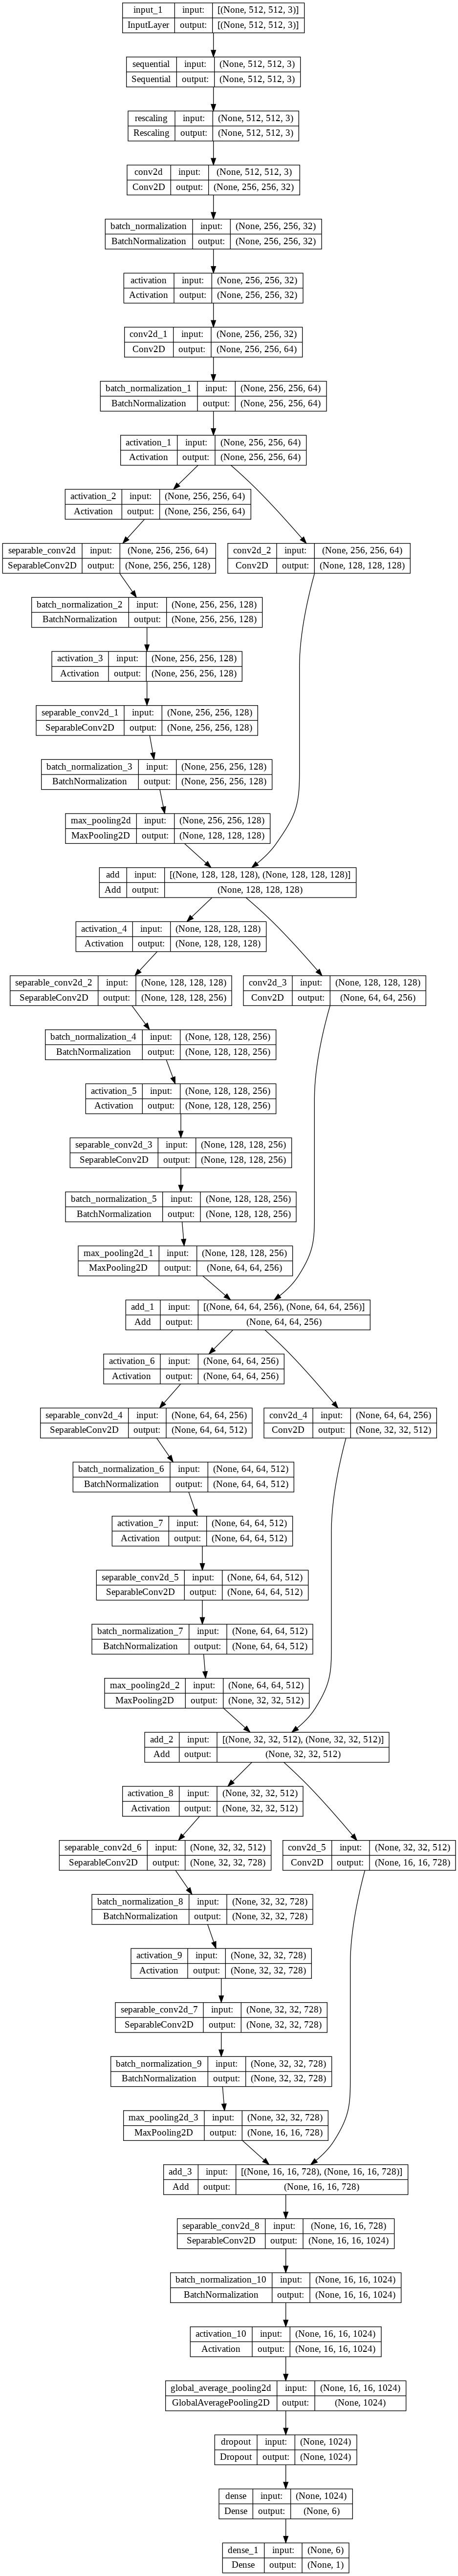

In [ ]:
model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 20

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, validation_data=val_ds,
)

Epoch 1/20
191/191 [==============================] - 412s 2s/step - loss: 0.6977 - accuracy: 0.5480 - val_loss: 0.6924 - val_accuracy: 0.5251
Epoch 2/20
191/191 [==============================] - 194s 1s/step - loss: 0.6795 - accuracy: 0.5493 - val_loss: 0.6919 - val_accuracy: 0.5251
Epoch 3/20
191/191 [==============================] - 194s 1000ms/step - loss: 0.6753 - accuracy: 0.5500 - val_loss: 0.6676 - val_accuracy: 0.5251
Epoch 4/20
191/191 [==============================] - 194s 1s/step - loss: 0.6740 - accuracy: 0.5500 - val_loss: 0.6973 - val_accuracy: 0.5251
Epoch 5/20
191/191 [==============================] - 194s 998ms/step - loss: 0.6735 - accuracy: 0.5450 - val_loss: 0.7005 - val_accuracy: 0.5251
Epoch 6/20
191/191 [==============================] - 194s 999ms/step - loss: 0.6694 - accuracy: 0.5719 - val_loss: 0.8723 - val_accuracy: 0.5575
Epoch 7/20
191/191 [==============================] - 193s 998ms/step - loss: 0.6669 - accuracy: 0.5814 - val_loss: 0.6792 - val_acc

In [ ]:
model.save('/content/gdrive/MyDrive/ANN/resultnc2345') 

In [ ]:
epochs = 20

model.fit(
    train_ds, epochs=epochs, validation_data=val_ds,
)

Epoch 1/20
191/191 [==============================] - 193s 996ms/step - loss: 0.6498 - accuracy: 0.6161 - val_loss: 0.6702 - val_accuracy: 0.6047
Epoch 2/20
191/191 [==============================] - 194s 1000ms/step - loss: 0.6506 - accuracy: 0.6155 - val_loss: 0.6598 - val_accuracy: 0.5723
Epoch 3/20
191/191 [==============================] - 194s 1s/step - loss: 0.6520 - accuracy: 0.6050 - val_loss: 0.6661 - val_accuracy: 0.5959
Epoch 4/20
191/191 [==============================] - 194s 999ms/step - loss: 0.6485 - accuracy: 0.6141 - val_loss: 0.6399 - val_accuracy: 0.6136
Epoch 5/20
191/191 [==============================] - 194s 999ms/step - loss: 0.6466 - accuracy: 0.6099 - val_loss: 0.6514 - val_accuracy: 0.6077
Epoch 6/20
191/191 [==============================] - 194s 1000ms/step - loss: 0.6452 - accuracy: 0.6145 - val_loss: 0.6514 - val_accuracy: 0.6047
Epoch 7/20
191/191 [==============================] - 194s 999ms/step - loss: 0.6400 - accuracy: 0.6236 - val_loss: 0.6553 - 